In [ ]:
!pip3 install hyperopt networkx==1.11

In [1]:
from copy import deepcopy
import pickle

import numpy as np
import matplotlib.pyplot as plt
import hyperopt

%matplotlib inline

In [2]:
trials_loc = "/storage/egor/tmp/function_dataset_from_CAT/io/best_trials_20180701.pkl"
with open(trials_loc, "rb") as f:
    trials = pickle.load(f)

In [3]:
def to_str(trial):
    trial_ = deepcopy(trial)
    del trial_["status"]
    del trial_["duration"]
    return str(trial_)


print("\n".join(to_str(i) for i in sorted(trials["trials"].results, key=lambda r: (r["val_acc"], r['test_acc']))))

{'val_acc': 0.42342342342342343, 'loss': 0.5765765765765766, 'test_acc': 0.41}
{'val_acc': 0.4264264264264264, 'loss': 0.5735735735735736, 'test_acc': 0.41333333333333333}
{'val_acc': 0.43543543543543545, 'loss': 0.5645645645645645, 'test_acc': 0.42333333333333334}
{'val_acc': 0.44144144144144143, 'loss': 0.5585585585585586, 'test_acc': 0.43666666666666665}
{'val_acc': 0.5045045045045045, 'loss': 0.49549549549549554, 'test_acc': 0.49}
{'val_acc': 0.5225225225225225, 'loss': 0.4774774774774775, 'test_acc': 0.4866666666666667}
{'val_acc': 0.5435435435435435, 'loss': 0.4564564564564565, 'test_acc': 0.5733333333333334}
{'val_acc': 0.5795795795795796, 'loss': 0.4204204204204204, 'test_acc': 0.6}
{'val_acc': 0.5855855855855856, 'loss': 0.4144144144144144, 'test_acc': 0.5833333333333334}
{'val_acc': 0.5915915915915916, 'loss': 0.4084084084084084, 'test_acc': 0.55}
{'val_acc': 0.5945945945945946, 'loss': 0.4054054054054054, 'test_acc': 0.6033333333333334}
{'val_acc': 0.5945945945945946, 'loss'

In [4]:
trials.keys()

dict_keys(['best_trial_dict', 'trials', 'space'])

In [5]:
hyper_space = trials["space"]

In [61]:
# hyperopt.space_eval(hyper_space, trials["trials"].argmin)


In [9]:
dir(trials["trials"])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_dynamic_trials',
 '_exp_key',
 '_ids',
 '_insert_trial_docs',
 '_trials',
 'aname',
 'argmin',
 'assert_valid_trial',
 'async',
 'attachments',
 'average_best_error',
 'best_trial',
 'count_by_state_synced',
 'count_by_state_unsynced',
 'delete_all',
 'fmin',
 'idxs',
 'idxs_vals',
 'insert_trial_doc',
 'insert_trial_docs',
 'losses',
 'miscs',
 'new_trial_docs',
 'new_trial_ids',
 'refresh',
 'results',
 'source_trial_docs',
 'specs',
 'statuses',
 'tids',
 'trial_attachments',
 'trials',
 'vals',
 'view']

In [31]:
for i, res in enumerate(trials["trials"].results):
    if res["test_acc"] == 0.9066666666666666:
        print(i)


21


In [65]:
best_hyper = dict((k, trials["trials"].trials[21]["misc"]["vals"][k][0]) 
                  for k in trials["trials"].trials[21]["misc"]["vals"])


def preapre_trial(trial):
    """
    Convert trial to correct format for hyperopt.space_eval
    """
    return dict((k, trial["misc"]["vals"][k][0]) for k in trial["misc"]["vals"])


best_hyper = preapre_trial(trials["trials"].trials[21])

In [62]:
# trials["trials"].argmin

In [34]:
type(trials["trials"].argmin), type(trials["trials"].trials[21])

(dict, dict)

In [67]:
trials["trials"].trials[21]
for key in hyperopt.space_eval(hyper_space, best_hyper)["bags"]:
    if "uast2seq" in key or "node2vec" in key:
        print(key)

uast2seq_weight
node2vec_n_steps
node2vec_q_leave_neighborhood
uast2seq_seq_len
node2vec_p_explore_neighborhood
node2vec_weight
uast2seq_stride
node2vec_stride
node2vec_n_walks
node2vec_seq_len
node2vec_seed


In [75]:
def trial_to_feat(trial, hyper_space):
    trial_ = preapre_trial(trial)
    trial_ = hyperopt.space_eval(hyper_space, trial_)
    
    res = {}
    
    extractors = ["id", "uast2seq", "graphlet", "lit", "node2vec", "children"]
    
    # feature extractors
    feature = trial_["bags"]["feature"]
    for extr in extractors:
        res[extr] = int(extr in feature)
    
    res["id_split_stem"] = trial_["bags"]["id_split_stem"]
    
    # weights of extractors
    get_weight = lambda r, name: r["bags"][name + "_weight"] * r["hash"][name + "_weight"]
    
    for extr in extractors:
        try:
            res[extr + "_weight"] = get_weight(trial_, extr)
        except:
            res[extr + "_weight"] = 1
    
    # hash parameters
    res["threshold"] = trial_["hash"]["threshold"]
    res["size"] = trial_["hash"]["size"]
    
    for key in trial_:
        if "uast2seq" in key or "node2vec" in key and "_weight" not in key:
            res[key] = trial_[key]
    
    return res

In [79]:
from collections import defaultdict


features = defaultdict(list)
assert len(trials["trials"].results) == len(trials["trials"].trials)
for trial, res in zip(trials["trials"].trials, trials["trials"].results):
    feat = trial_to_feat(trial, hyper_space)
    for key in feat:
        features[key].append(feat[key])
    features["val_acc"].append(res["val_acc"])
    features["test_acc"].append(res["test_acc"])

In [81]:
import pandas as pd

feat_df = pd.DataFrame.from_dict(features)


feat_df

,children,children_weight,graphlet,graphlet_weight,id,id_split_stem,id_weight,lit,lit_weight,node2vec,node2vec_weight,size,test_acc,threshold,uast2seq,uast2seq_weight,val_acc
0,0,1,0,71832.611998,1,False,694.029484,0,619.777114,0,1,256,0.803333,0.517688,1,218.211935,0.831832
1,0,1,1,164211.444116,1,True,233.674432,0,244.668564,0,1,128,0.660000,0.916924,0,511.465651,0.654655
2,0,1,0,9842.775003,1,True,288.841843,1,835.192632,0,1,160,0.806667,0.402518,1,867.895825,0.831832
3,0,1,1,248581.990554,1,False,986.077225,0,312.538590,0,1,256,0.833333,0.439346,0,123.813724,0.843844
4,0,1,1,128163.570580,1,True,341.130467,1,762.560105,0,1,160,0.833333,0.410221,1,569.741783,0.858859
5,0,1,1,253134.543681,1,True,63.550748,1,784.429644,0,1,128,0.853333,0.526026,1,57.497959,0.879880
6,0,1,0,165127.648438,1,False,439.076070,1,46.005227,0,1,96,0.716667,0.597508,1,930.709458,0.750751
7,0,1,1,153938.330439,1,False,281.323692,1,454.421078,0,1,128,0.790000,0.770537,0,751.246362,0.792793
8,0,1,1,348349.171971,1,True,774.505771,0,445.833372,0,1,256,0.813333,0.464023,0,614.657909,0.804805
9,0,1,1,182348.526004,1,False,379.898187,1,362.980707,0,1,192,0.873333,0.525566,1,672.306906,0.858859


In [86]:
(feat_df["id"] == 0).sum()

0

In [87]:
corr = (feat_df[["graphlet", "graphlet_weight", "id_split_stem", "id_weight",
                 "lit", "lit_weight", "size", "threshold", "uast2seq", "uast2seq_weight",
                 "test_acc", "val_acc"]].corr())

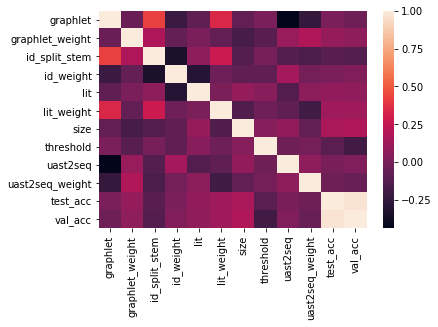

In [88]:
import seaborn as sns


sns.heatmap(corr)

In [89]:
from sklearn.ensemble import RandomForestRegressor
x = feat_df[[col for col in feat_df.columns if col not in ["test_acc", "val_acc"]]]

y = feat_df["val_acc"]
yt = feat_df["test_acc"]

rf = RandomForestRegressor()

rf.fit(x, y)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [91]:
for feat, imp in zip(x.columns, rf.feature_importances_):
    print(feat, imp)

children 0.0
children_weight 0.0
graphlet 0.009209526532584982
graphlet_weight 0.034871357613636265
id 0.0
id_split_stem 0.006123633888672541
id_weight 0.0911697940637393
lit 0.012440967042398984
lit_weight 0.07980801067540085
node2vec 0.0
node2vec_weight 0.0
size 0.04272613951355665
threshold 0.6395586998819404
uast2seq 0.0013875361898190554
uast2seq_weight 0.08270433459825091


In [92]:
rf.score(x, y), rf.score(x, yt)

(0.9027229060291022, 0.8044226930832143)

In [107]:
preds = rf.predict(x)
for gt, gtt, pred in zip(y.tolist(), yt.tolist(), preds):
    print("%.4f\t%.4f\t%.4f" % (gt, gtt, pred))

0.8318	0.8033	0.8553
0.6547	0.6600	0.6486
0.8318	0.8067	0.7643
0.8438	0.8333	0.8429
0.8589	0.8333	0.8541
0.8799	0.8533	0.8712
0.7508	0.7167	0.7922
0.7928	0.7900	0.7826
0.8048	0.8133	0.8192
0.8589	0.8733	0.8589
0.8559	0.7900	0.8604
0.6306	0.6433	0.6345
0.8799	0.8500	0.8793
0.7838	0.7833	0.7808
0.8498	0.8167	0.8508
0.7868	0.8100	0.7763
0.6607	0.6600	0.7219
0.6366	0.6567	0.6949
0.8018	0.7800	0.7544
0.6787	0.6633	0.7081
0.8799	0.8467	0.8907
0.9159	0.9067	0.9099
0.6817	0.7200	0.7039
0.9009	0.8733	0.9045
0.9099	0.8767	0.8880
0.8769	0.8567	0.8541
0.7357	0.7567	0.7315
0.7718	0.7633	0.7769
0.5796	0.6000	0.5949
0.8979	0.8800	0.8859
0.8859	0.8900	0.8661
0.5856	0.5833	0.6243
0.8769	0.8800	0.8721
0.7928	0.7533	0.7988
0.7688	0.7633	0.7736
0.7237	0.7300	0.7297
0.8168	0.8067	0.8264
0.6366	0.6500	0.6420
0.5225	0.4867	0.5814
0.8258	0.8133	0.8480
0.8559	0.8300	0.8694
0.7958	0.7967	0.8255
0.6847	0.6833	0.7201
0.6817	0.6700	0.6556
0.8018	0.7967	0.8051
0.8468	0.8567	0.8423
0.8889	0.8433	0.8486
0.7838	0.7500